## Markov Chain for Forward Diffusion Process

**Core Concept:**

In this concept, The forward diffusion process is a Markov chain that progressively adds Gaussian noise to data, transforming it into a sample from a standard Gaussian distribution.

**Formal Definition:**

Given an initial data point x₀ and a variance schedule β₁, β₂, ..., βₜ, the forward diffusion process can be defined by the following iterative equation:


`xₜ = √(1 - βₜ)xₜ₋₁ + √βₜ ε`

**where:**

**xₜ:** The data point at time step 't'.

**xₜ₋₁:** The data point at the previous time step 't-1'.

**βₜ:** The variance of the Gaussian noise added at time step 't'.

**ε:** A random sample drawn from a standard Gaussian distribution.

**Markov Property:**

The process is Markov because the state at time step 't' (xₜ) depends only on the state at the previous time step 't-1' (xₜ₋₁) and the noise added at that step.

**Noise Schedule:**

The noise schedule (β₁, β₂, ..., βₜ) determines how much noise is added at each step. It is often chosen to be a monotonically increasing sequence, leading to a gradual corruption of the data.

**Transition Probability:**

The transition probability from xₜ₋₁ to xₜ is given by a Gaussian distribution with mean √(1 - βₜ)xₜ₋₁ and variance βₜ.

**Stationary Distribution:**

As 't' approaches infinity, the distribution of xₜ converges to a standard Gaussian distribution.

**Significance in Diffusion Models:**

**Data Generation:** By reversing the forward diffusion process, diffusion models can generate new data samples by gradually removing noise from a sample drawn from a standard Gaussian distribution.

**Training:** The forward diffusion process is used to create training data for the reverse diffusion process, allowing the model to learn the denoising process.


**In Essence:**

The Markov Forward Diffusion process is a systematic way to inject noise into data using a Markov chain with a Gaussian transition kernel. This process forms the foundation of diffusion models, enabling them to generate new data by learning to reverse this noise injection process.

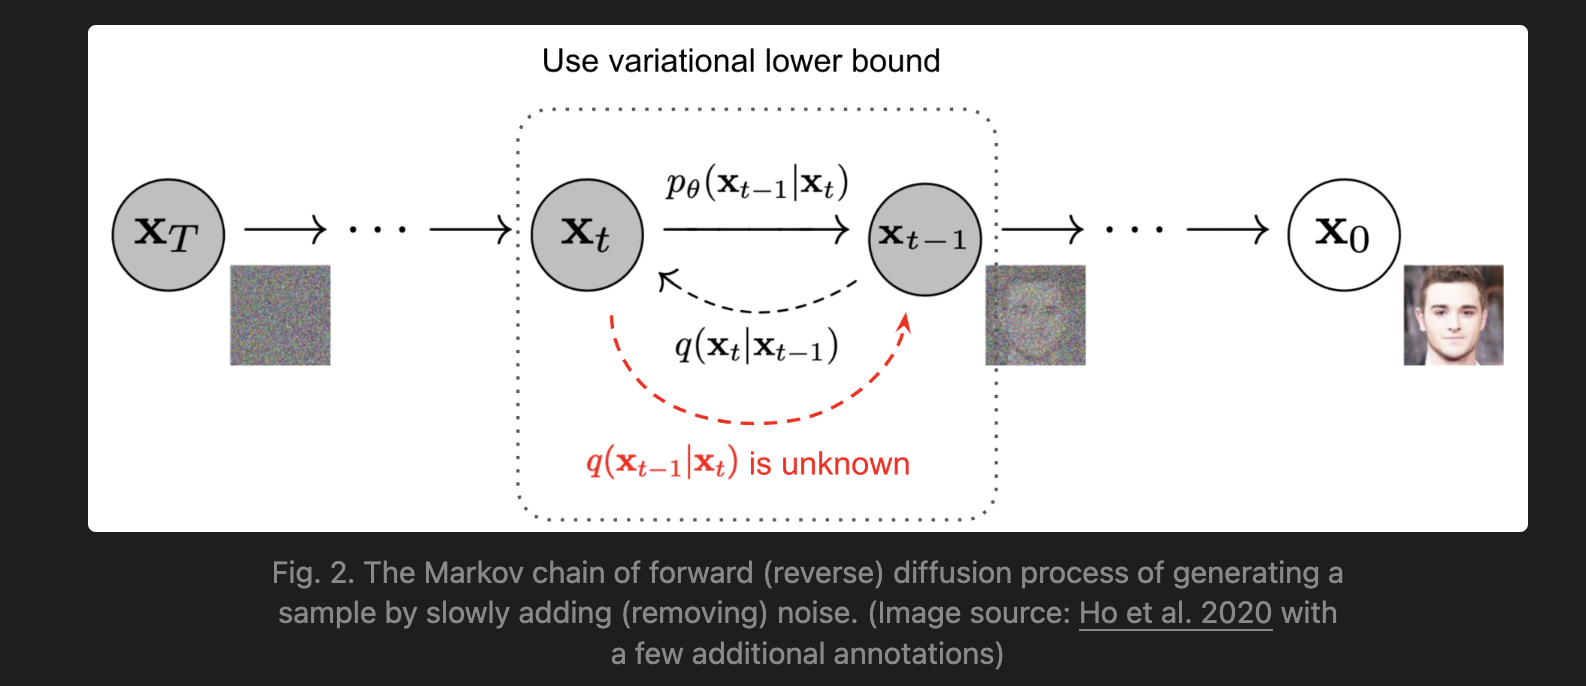



**Image Interpretation:**

The figure shows how the forward diffusion process systematically introduces noise, gradually corrupting the original data until it becomes indistinguishable from pure Gaussian noise. This noise-corrupted data is crucial for training the reverse diffusion process in diffusion models.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict

**Explanation of the terms in return statement**



```
xₜ = √(1 - βₜ)xₜ₋₁ + √βₜ ε
```


**betas:** This refers to the noise schedule itself, represented as a sequence of variance values (β₁, β₂, ..., βₜ). These values determine how much noise is added at each time step (t) of the forward diffusion process. They are typically chosen to increase monotonically over time, meaning more noise is added as the process progresses.

**alphas:** These are calculated as 1 - betas for each time step. They represent the signal scaling factor. As betas increase, alphas decrease, meaning the original data signal is gradually attenuated during diffusion.

**alphas_cumprod: **This term represents the cumulative product of alphas. It's the product of all alpha values up to a particular time step. This cumulative product reflects the overall signal attenuation that has occurred up to that point.

**sqrt_alphas_cumprod:** This is the square root of alphas_cumprod. It's used in the forward diffusion equation to scale down the previous data point (xₜ₋₁) before adding noise.

**sqrt_one_minus_alphas_cumprod:** This is the square root of 1 - alphas_cumprod. It's used in the forward diffusion equation to scale the added noise (ε) before adding it to the scaled-down data point.



In [2]:
def create_diffusion_schedule(num_timesteps: int = 1000,
                            beta_start: float = 1e-8,
                            beta_end: float = 0.02) -> Dict[str, tf.Tensor]:
    """
    Create diffusion schedule parameters
    """
    betas = tf.linspace(beta_start, beta_end, num_timesteps)
    alphas = 1 - betas
    alphas_cumprod = tf.math.cumprod(alphas)

    return {
        'betas': betas,
        'alphas': alphas,
        'alphas_cumprod': alphas_cumprod,
        'sqrt_alphas_cumprod': tf.sqrt(alphas_cumprod),
        'sqrt_one_minus_alphas_cumprod': tf.sqrt(1 - alphas_cumprod)
    }


In [3]:
# Markov

def add_noise_and_get_prob(x: tf.Tensor,
                          t: int,
                          schedule: Dict[str, tf.Tensor]) -> Tuple[tf.Tensor, tf.Tensor]:
    """
    Add noise to image and calculate transition probability
    """
    noise = tf.random.normal(tf.shape(x))
    x_noisy = schedule['sqrt_alphas_cumprod'][t] * x + \
              schedule['sqrt_one_minus_alphas_cumprod'][t] * noise

    # Calculate per-pixel probabilities
    mean = schedule['sqrt_alphas_cumprod'][t] * x
    var = 1 - schedule['alphas_cumprod'][t]

    # Calculate log probabilities for numerical stability
    log_prob = -0.5 * tf.square(x_noisy - mean) / var - 0.5 * tf.math.log(2 * np.pi * var)

    # Average over spatial dimensions and channels, keep batch dimension
    avg_log_prob = tf.reduce_mean(log_prob, axis=[1, 2, 3])

    # Convert to probabilities
    prob = tf.exp(avg_log_prob)

    return x_noisy, prob


In [4]:
def plot_diffusion_process(original_images: tf.Tensor,
                          noisy_images: List[tf.Tensor],
                          probs: List[tf.Tensor],
                          timesteps: List[int]):
    """
    Plot the diffusion process with transition probabilities
    """
    num_images = min(5, original_images.shape[0])
    num_steps = len(noisy_images) + 1

    plt.figure(figsize=(15, 3*num_images))

    for idx in range(num_images):
        # Plot original
        plt.subplot(num_images, num_steps, idx*num_steps + 1)
        plt.imshow(original_images[idx, ..., 0], cmap='gray')
        plt.title('Original')
        plt.axis('off')

        # Plot noisy versions
        for step in range(len(noisy_images)):
            plt.subplot(num_images, num_steps, idx*num_steps + step + 2)
            plt.imshow(noisy_images[step][idx, ..., 0], cmap='gray')
            prob_value = float(probs[step][idx].numpy())
            plt.title(f't={timesteps[step]}\np(t|t-1)={prob_value:.3f}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()


In [5]:

def load_and_preprocess_data():
    """
    Load and preprocess Fashion MNIST dataset
    """
    dataset = tfds.load('fashion_mnist', split='train', as_supervised=True)
    dataset = dataset.map(lambda x, _: tf.cast(x, tf.float32) / 127.5 - 1)
    dataset = dataset.batch(32).take(1)
    return next(iter(dataset))


In [6]:
def main():
    # Initialize diffusion schedule
    schedule = create_diffusion_schedule(num_timesteps=1000)

    # Load and preprocess data
    images = load_and_preprocess_data()

    # Generate diffusion steps
    timesteps = [50, 100, 150, 200, 250]
    noisy_images = []
    probs = []

    current_images = images
    for t in timesteps:
        noisy_image, prob = add_noise_and_get_prob(current_images, t, schedule)
        noisy_images.append(noisy_image)
        probs.append(prob)
        current_images = noisy_image

    # Visualize
    plot_diffusion_process(images, noisy_images, probs, timesteps)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.WIVQLD_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.WIVQLD_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


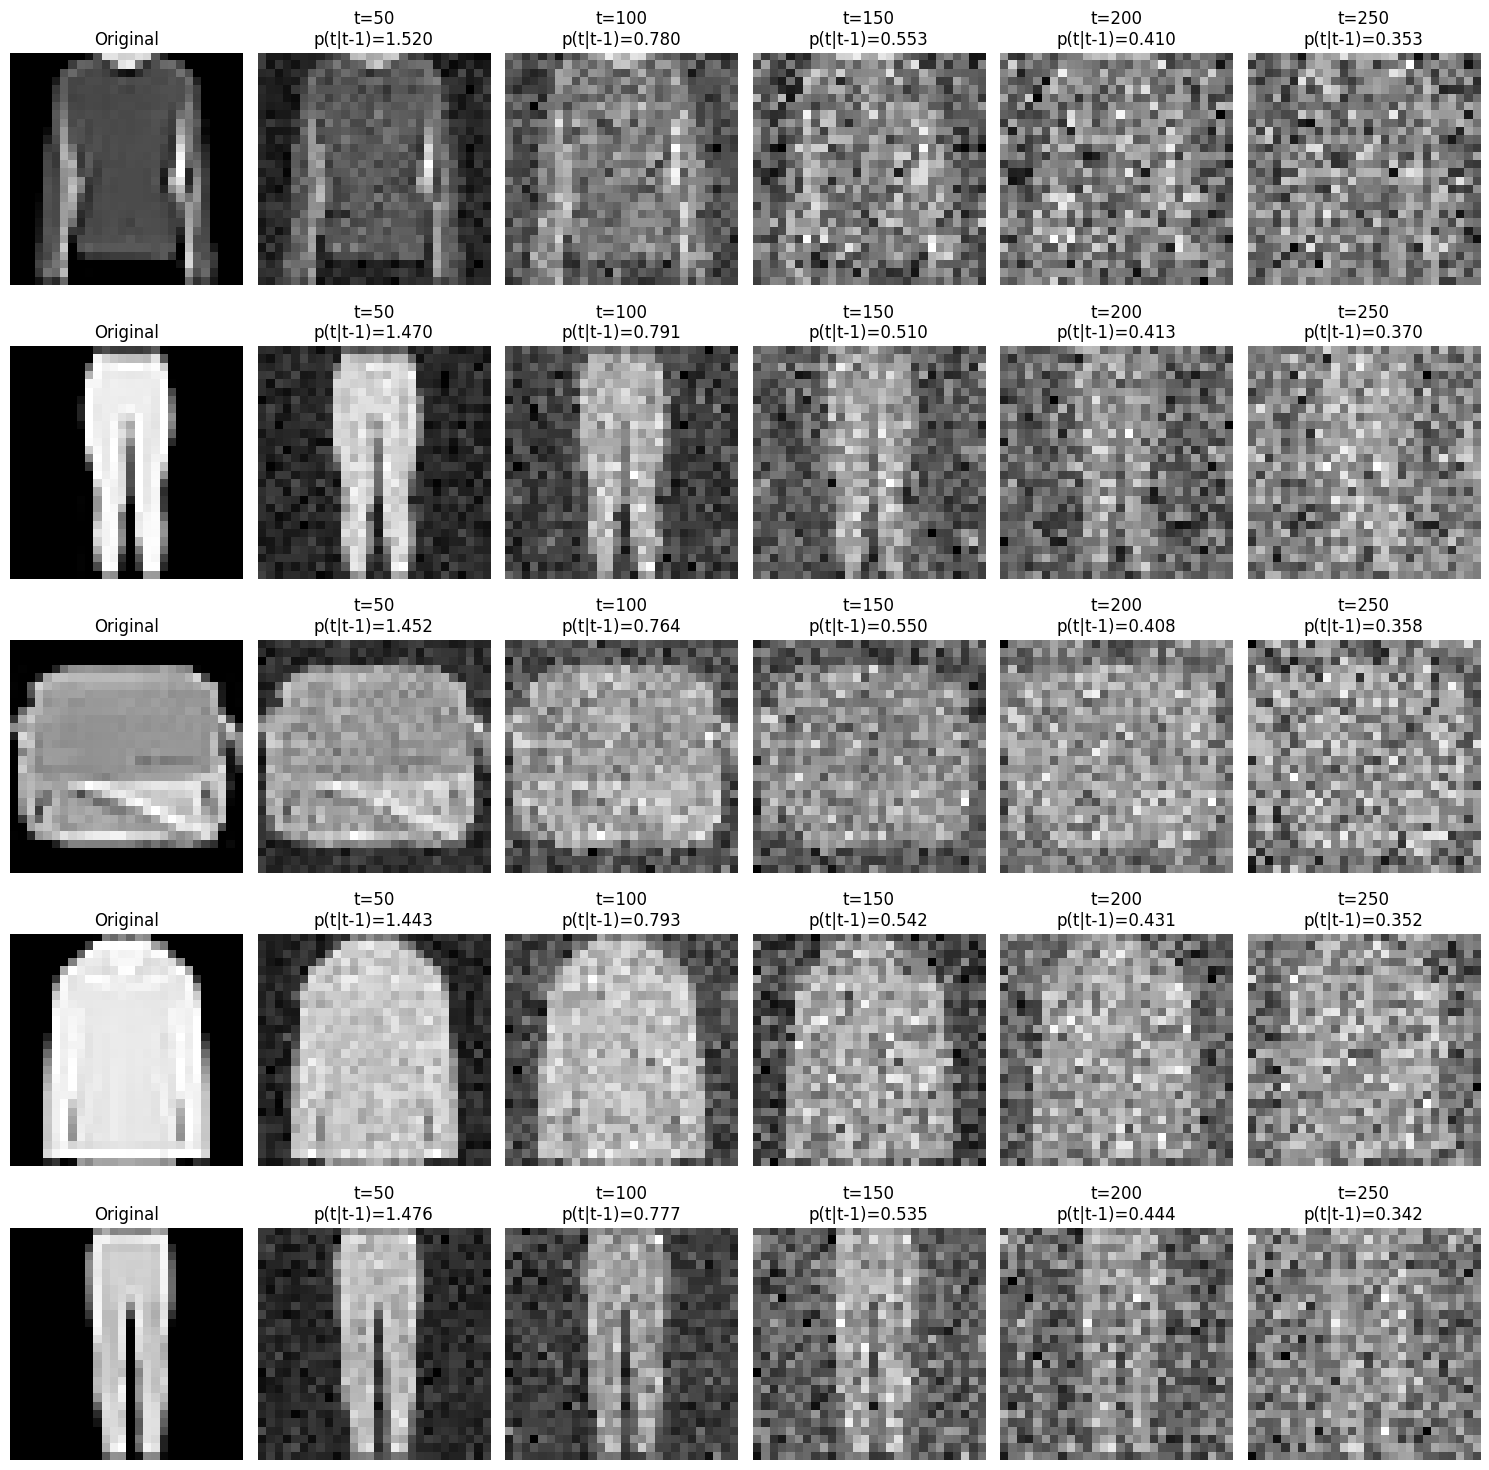

In [7]:
if __name__ == "__main__":
    main()

The output of the forward diffusion process is a sequence of progressively noisier versions of the input data (e.g., images). The final output is essentially pure noise, sampled from a standard Gaussian distribution.

**Interpretation:**

**Gradual Corruption:** Each step of the forward diffusion process introduces a controlled amount of noise, causing the original data to become increasingly corrupted. This gradual corruption is essential for training diffusion models to learn the reverse process (denoising).

**Intermediate States:** The intermediate outputs represent snapshots of the data as it transitions from its clean state to pure noise. These intermediate states capture the different levels of noise introduced at each step and are crucial for training diffusion models to reverse the process.

**Consider the trousers image:**

1. **Original (t=0)**: The trousers image is like a "perfect" version of the data — the clear, sharp image without any corruption.

2. **t=50**: As the process starts, some noise is introduced, making the trousers image appear less defined but still recognizable.

3. **t=100**: The image becomes blurrier and more noisy, with key details of the trousers starting to fade. It's still somewhat identifiable, but much more corrupted.

4. **t=150**: The noise level increases further, and now the trousers image is hard to recognize. It starts looking more like abstract noise than a clear image.

5. **t=200**: At this point, most of the image's structure has been lost, leaving behind only blurry fragments. It is much closer to pure noise than the original image.

6. **t=250**: The trousers image is now almost entirely noise, with no recognizable features left. It's just a random collection of pixels, far removed from the original clear image.

So, in this analogy:
- **The original image (t=0)** is "god-like," clear, and perfect.
- As the time steps increase, **the image degrades** and becomes more corrupted, eventually reaching pure noise at t=250.

Each step represents how the image is gradually destroyed (by adding noise), which is key to training models to reverse the process (denoising).